<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

Execute cell below to get table of contents

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from googletrans import Translator
from scipy.stats import median_absolute_deviation
from collections import Counter, OrderedDict
from nltk.corpus import wordnet
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# In the past
We had ideas at first to analyse the dataset from OpenFoodFacts and consider mainly the carbon footprint of the products. Based on advices from the Teaching Assitants of the course, and our own analysis, compared to the dataset of over a million products, only a few thousands of them actually had a value for carbon footprint. 
Thus, we decided to drop this idea and went on to discover which one were considered unhealthy, and from then base this project.

# Initial cleaning of the dataset


In this part, we load the original [openfoodfacts](https://world.openfoodfacts.org/) dataset into a pandas dataframe. There is one row for each product, and the columns contain different information about this product, such as for example amount of sugar or the additives. After inspection of the original data, we decided to remove the columns in which more than 850k items have a missing value. This step allows us to considerably reduce the size of the dataset, without loosing much information. We don't run this part of the notebook anymore (start at Initial data analysis with the cleaned data set).

In [6]:
openfacts_path='Data/en.openfoodfacts.org.products.csv' 

In [7]:
df_of=pd.read_csv(openfacts_path,encoding='UTF-8',sep='\t') # Open original dataset

/home/samuel/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# define dictionnary containing the data
col_dict={}
for j,i in enumerate(df_of.columns):
    col_dict[j]=i

Clean Columns of df_of, by removing those with more than 850k of nans in them. Removing the columns with more than 850k still leaves us with 57 columns.

In [9]:
df_of_clean=pd.DataFrame() 
for j,i in enumerate(df_of.columns):
    if sum(df_of[i].isna())<850000:
        df_of_clean[i]=df_of[i]

We store the reduced dataset into a pickle file in order to reuse is for the rest of the analysis. 

In [10]:
df_of_clean.to_pickle('Data/df_openfacts_small.pkl')


In [5]:
#plt.plot(np.sort(nnan))
#plt.title("Number of NaN per columns")
#plt.show()

In [6]:
#df_sugar=df_tmp[df_tmp['sugars_100g']<100]
#df_sugar=df_sugar[df_sugar['sugars_100g']>0]

In [7]:
#np.mean(df_sugar['sugars_100g'])

In [8]:
#plt.hist(df_sugar['sugars_100g'],bins=25)
#plt.show()

In [9]:
#df_sugar.shape

# Initial data analysis with the cleaned dataset

In this part, we work with the cleaned dataset, provided by the previous section of the notebook. We will focus on the products containing information about their nutrition grade. The nutrition grade ranges from "A" to "E", "A" being the best (i.e. healthiest) label and "E" the worst. Additional information about the nutrition score, and how it is computed can be found [here](https://fr.openfoodfacts.org/nutriscore?fbclid=IwAR3gF2UqQFGghwxNmyAGQjex07SzRXbHT510X658PuNykZXSdVXN0IokETg). The initial plots in this part, give us a intuition about the relationship between the nutritional grade of the products and some other information provided about them, such the content of the products.  

We define the following functions in order to clean and plot the dataset.

In [3]:
def clean_nan(df,var):
    '''Given a dataframe df and a column var, returns a copy of df where the items for
    which var is a nan have been removed'''
    return df[df[var].isna()==False].copy()

In [4]:
def remove_outliers(df,var,k=3):
    '''Uses the MAD criterion to remove outliers. The data must be free of nans.
    Values that are above or below K times the MAD are removed from the data,
    and a copy of the dataframe is returned'''
    mad=median_absolute_deviation(df[var])
    mean=np.mean(df[var])
    return df[np.logical_and(df[var].values<mean+k*mad,df[var].values>mean-k*mad)].copy()

In [5]:
def dist_nutritiongrade(df,var,bw=0.5,bins=8):
    '''plots kernel desnsity estimation  of the values of column var, given the 
    nutrition grade'''
    df=remove_outliers(clean_nan(df,var),var)
    fig, ax=plt.subplots(figsize=(5,5))
    for ns in np.unique(df['nutrition_grade_fr']):
        sns.distplot(df[df['nutrition_grade_fr']==ns][var],label=ns,ax=ax,\
                     kde_kws={"bw": bw},bins=bins)
    plt.legend()
    plt.show()

In [6]:
def boxplot_nutritiongrade(df,var):
    '''plots a boxlot of column var, given the nutrition grade'''
    df=remove_outliers(clean_nan(df,var),var)
    fig, ax=plt.subplots(figsize=(5,5))
    sns.boxplot(x="nutrition_grade_fr", y=var, data=df,order=['a','b','c','d','e'],ax=ax)
    plt.show()

In [7]:
# Load the clean dataset
df_of_clean=pd.read_pickle('Data/df_openfacts_small.pkl')

Let us take a look at our dataframe :

In [8]:
print(df_of_clean.shape) # we still have 57 columns
df_of_clean.head()

(1023451, 57)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,7.0,3.08,70.1,15.0,NaN,7.8,1.40,0.560,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,dgesc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,0.0,0.00,4.8,0.4,NaN,0.2,2.04,0.816,NaN,NaN
4,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,3.0,1.00,10.0,3.0,NaN,2.0,1.15,0.460,NaN,NaN


In [8]:
cols_list=df_of_clean.columns
print(cols_list)

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_en', 'labels', 'labels_tags',
       'labels_en', 'stores', 'countries', 'countries_tags', 'countries_en',
       'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n',
       'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags',
       'states_en', 'main_category', 'main_category_en', 'image_url',
       'image_small_url', 'image_ingredients_url',
       'image_ingredients_small_url', 'image_nutrition_url',
       'image_nutrition_small_url', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
     

Since our analysis will be performed on the nutrition grade of the products, we only keep the items for which the nutrion grade is given. This reduces our dataset to about 280k rows. 

In [9]:
df_ns=df_of_clean[df_of_clean['nutrition_grade_fr'].isna()==False].copy()

We extract the names of the columns that correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product, in order to use them later on to produce some plots revealing the relationships between the nutrion grade and the content of the product.

In [10]:
# names of the columns that provide quantitative facts per 100g of product
facts_100g=['energy_100g', 'fat_100g','saturated-fat_100g',
            'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
            'proteins_100g', 'salt_100g', 'sodium_100g']

Before proceeding with our analysis, we verify that the nutrition grade indeed ranges from a to e.

In [12]:
ng_f=df_ns['nutrition_grade_fr']
print(np.unique(df_ns['nutrition_grade_fr']))

['a' 'b' 'c' 'd' 'e']


In [13]:
df_ns.shape

(289750, 57)

In [15]:
## We also define a dataframe in which we remove outliers and all nans from the dataset 
df_ns_small=df_ns.copy()
for var in facts_100g:
    df_ns_small=remove_outliers(clean_nan(df_ns_small,var),var)

In [16]:
## we end up with very few raws, so not very convenient!
df_ns_small.shape

(13499, 57)

## Analysis of the dataset according to the nutrition score

Now that the functions have been defined and the dataset cleaned, we plot kernel density estimations and boxplots of other quantitative facts about the products. These plots allow us to better understand what the nutrition grade represents, by seing how it impacts the contents of the products.

### Kernel density estimations
We start with the columns 'nutrition-score-uk_100g' and 'nutrition-score-fr_100g'. These two columns contain a nutrition score defined respectively by the UK Food Standards Administration (FSA) and the french score is derived from the UK FSA score and adapted for the French market

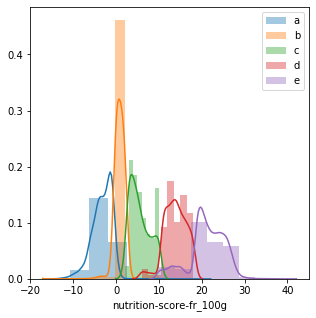

In [17]:
dist_nutritiongrade(df_ns,'nutrition-score-fr_100g',bw=0.7)

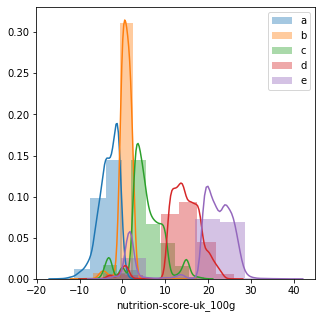

In [18]:
dist_nutritiongrade(df_ns,'nutrition-score-uk_100g',bw=0.7)

##### Analysis of the KDE 
The two above plots, reveal that the both the UK and French nutrition scores clearly categorize the data in a way similar to the nutrition grade. They approximately range from -10 to 30, the lower the better. We can say that they convey the same information as the nutrition grade, since both plots clearly show that one could map almost bijectively the labels "a" to "e" to corresponding intervals of values between -10 and 30.

In [19]:
#for var in facts_100g:
    #dist_nutritiongrade(df_ns,var,bw=1)

### Boxplots 
We now plot boxplots with the dataset, cleaning only the column that we need to plot :

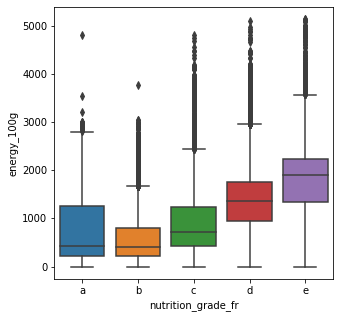

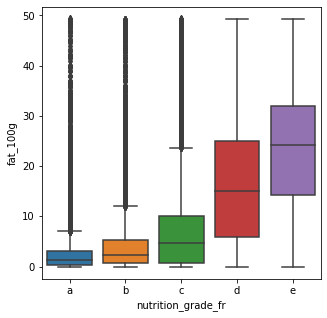

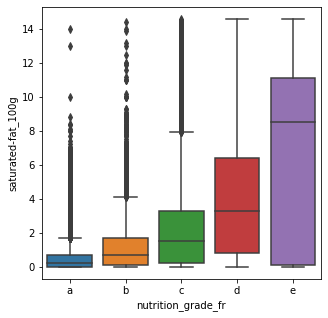

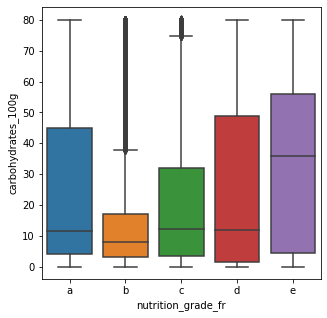

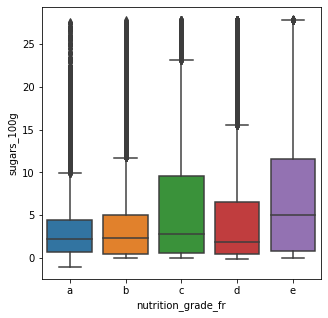

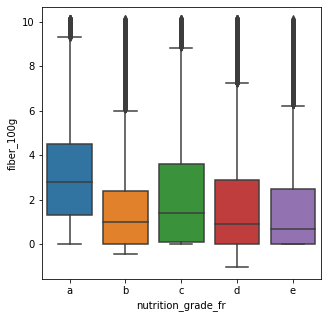

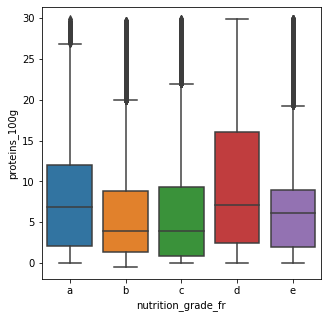

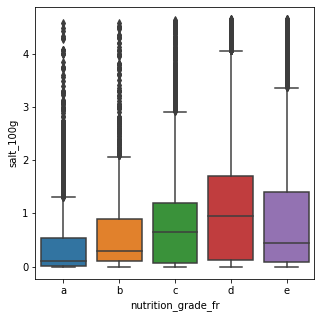

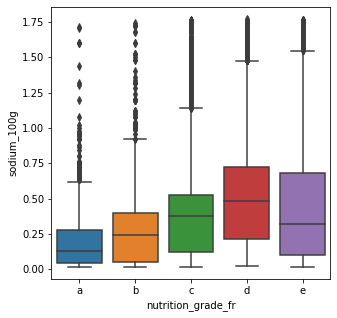

In [20]:
for var in facts_100g:
    boxplot_nutritiongrade(df_ns,var)

##### Analysis of the boxplots :
- Energy : The amount of calories in 100g of food increases almost linearly with respect to their nutrition grade (no surprises here, the "unhealthier" the product, the more calorific it is). Products in category "a" show a slightly bigger variance around the median in their amount of energy, than the products of the other categories. The reason behind this is probably that category "a" contains two kinds of very different products from a nutritional point of view. On the one hand, it contains all the fruit and vegetables, which are poor in calories, but it also contains starchy foods such as some type of pasta or rice, which contain significantly higher amounts of energy than the vegetables. 
- Fat : The median fat amount of the products seems to increase in a quadratic fashion with respect to their nutrion grade. Also, the amount of fat in the products becomes more and more spread out. This could be due to the fact that the unhealthy products could be separated into several more categories (i.e. degree of "unhealthiness"). Indeed, when thinking for example about regular milk chocolate and nutella, both products belong to category "e", but the latter is in a sense much unhealthier than the first one. In other words, some products are unhealthy because they contain a little bit too much fat, but in others the amount of fat is pushed to extreme degrees. One can also observe a shift when passing from category "c" to "d". While a lot of products in the first categories don't contain any fat at all, the middle 50% of the data in "d" contains at least 5g of fat.
- Saturated Fat : Almost the same observations as for the fat boxplot. One difference is that the lower quartile for categories "d" and "e" remains almost 0, while the upper quartile increases a lot when changing categories. Thus, the variance in amounts of saturated fats increases a lot when dealing with the unhealthy products.
- Carbohydrates : The median amount of carbohydrates is much higher for elements in "e" compared to the other grades. Furthermore, the box in "b" is significantly smaller than for the other categories. This is explained by the fact that category "b" contains mainly dairy and animal products (fish, meat) which both contain a low amount of carbohydrates.
- Sugars : The median amount of sugar is higher for products in "e" than for the other grades. The upper quartile is also significantly higher than for the other categories. Surprisingly, products in "c" seem to contain more sugar than the ones in "d" (higher median and upper quartile). This inconsistency is not suprising when we look at the large amount of outliers for boxplot "d".
- Fiber : Products in "a" show significantly higher amounts of fibers than products in the other categories.
- Proteins : No distinct paterns and relationship emerge between the amount of proteins and the nutritional grade. 
- Salt : The median and upper quantile increases linearly up to grade "d", and then decreases again for products in "e". This indicates that category "d" contains the salty products such as some kinds of cheese or potato chips, and that the unhealthiest products still remain products that are mainly sweet. 
- Sodium : Similar conclusions to the ones made about the salt boxplot can be drawn.


##### Boxplots with the reduced dataset 

We also plotted some boxplots with the **reduced dataset** (i.e. the dataset where all NaNs have beeen removed) in order to see if the analysis differs to the one made about the previous boxplots. 

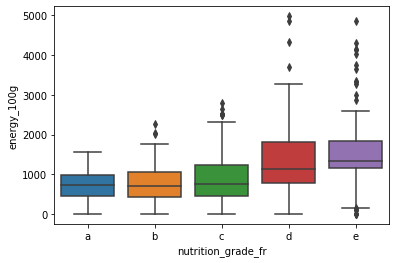

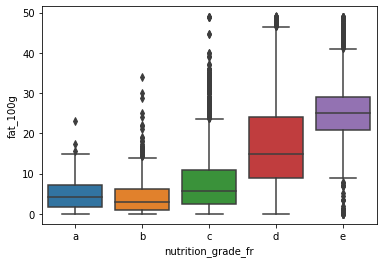

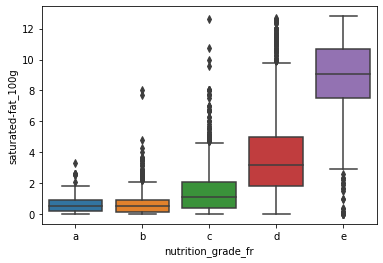

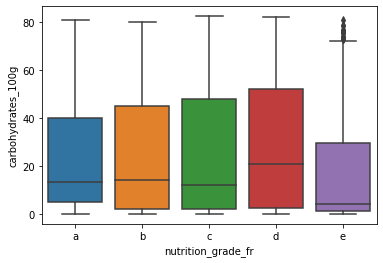

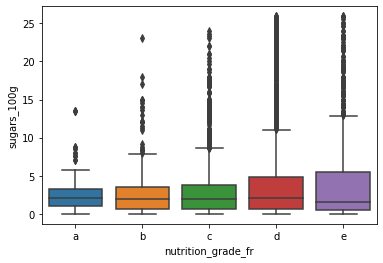

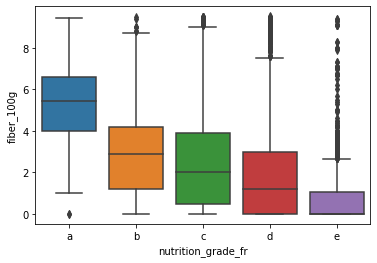

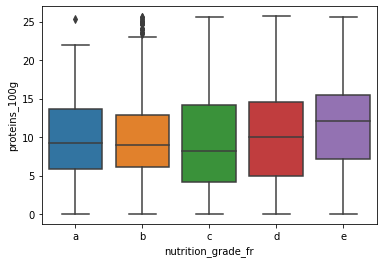

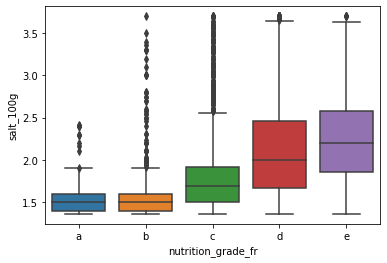

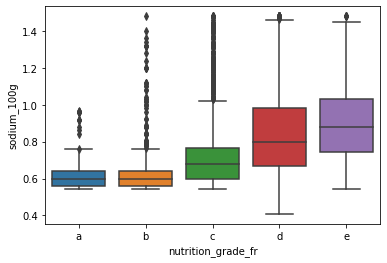

In [21]:
# boxplot with the reduced dataset
for var in facts_100g:
    fig,ax=plt.subplots()
    sns.boxplot(x="nutrition_grade_fr", y=var, data=df_ns_small,order=['a','b','c','d','e'],ax=ax)

**Analysis of the boxplots** :
Overall, the lower and upper quartiles of these boxplots are much closer for these boxplots than for the previous ones (i.e. less variance around the median). We will now discuss separately te boxplots showing different results to the previous ones.
- Saturated Fat : the trend according to which the amount of saturated fat increases quadraticaly with the grade of the products is seen clearer in this boxplot. 
- Sugars : the relationship between amount of sugar and grade is more difficult to see in these boxplots. Too much information has been lost.
- Fiber : One can see even clearer the difference in amount of fibers between products in "a" and the remaining of the products. Also there is clearly a decreasing trend, the unhealthier the products, the less fibers they contain.
- Salt and Sodium : We don't observe the same drop in amounts of salt/sodium between categories "d" and "e" as previously. 

## Focus on the worst nutrition score

In some next steps of our analysis, we will want to especially focus on products having a nutrition grade of "e". After linking this dataset to the [instacart](https://www.instacart.com/) dataset, we will research if some interesting patterns emerge about these products from a consumer point of view.
In this part we create a dataframe containing only the products with the worse nutrition grade, for later use.

In [22]:
df_e=df_ns[df_ns['nutrition_grade_fr']=='e'].copy()

In [23]:
df_e.shape

(56563, 57)

In [24]:
facts_grade_e=['energy_100g', 'fat_100g']

In [25]:
df_e_small=df_e.copy()
for var in facts_grade_e:
    df_e_small=remove_outliers(clean_nan(df_e_small,var),var)

In [26]:
df_e_small

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
11965,11863118764,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489066350,2017-03-09T13:32:30Z,1535680058,2018-08-31T01:47:38Z,"Bellavitano, Merlot Cheese",150 g,Envoltura de plastico,...,30.00,20.00,6.67,0.00,0.00,26.70,1690.000000,677.000000,25.0,30.0
84114,680813,http://world-en.openfoodfacts.org/product/0068...,openfoodfacts-contributors,1569000770,2019-09-20T17:32:50Z,1569001950,2019-09-20T17:52:30Z,Maxi Burger charolais,195g,NaN,...,24.80,10.30,46.00,3.10,NaN,28.10,1.880000,0.752000,28.0,28.0
104356,74323046199,http://world-en.openfoodfacts.org/product/0074...,usda-ndb-import,1489062284,2017-03-09T12:24:44Z,1551563010,2019-03-02T21:43:30Z,Cajeta Quemada,660 g,Botella de plastico,...,8.33,8.33,66.70,46.70,0.00,6.67,296.000000,119.000000,38.0,38.0
114462,77975089156,http://world-en.openfoodfacts.org/product/0077...,usda-ndb-import,1489057254,2017-03-09T11:00:54Z,1571271950,2019-10-17T00:25:50Z,Mini Pretzels,226.8 g,Bolsa de plastico,...,6.67,3.33,83.30,1.67,3.33,0.00,3980.000000,1590.000000,20.0,20.0
116531,78742085296,http://world-en.openfoodfacts.org/product/0078...,usda-ndb-import,1489142282,2017-03-10T10:38:02Z,1541008192,2018-10-31T17:49:52Z,Deli Style Sliced Mild Cheddar Cheese,227 g,Bolsa de plastico,...,31.60,18.40,0.00,0.00,0.00,26.30,1600.000000,642.000000,25.0,30.0
117762,78742283357,http://world-en.openfoodfacts.org/product/0078...,zoneblockscommunity,1471740813,2016-08-21T00:53:33Z,1540841365,2018-10-29T19:29:25Z,Parmesan Cheese,170 g,Bosla de plastico resellable,...,25.00,14.30,3.57,0.00,0.00,35.70,3080.000000,1230.000000,25.0,30.0
129317,94331410560,http://world-en.openfoodfacts.org/product/0094...,usda-ndb-import,1489069466,2017-03-09T14:24:26Z,1551634087,2019-03-03T17:28:07Z,"Granvita, Granola Cereal With Fruit",400 g,Bolsa de plastico,...,11.20,2.00,62.80,22.00,8.50,11.50,57.100000,22.900000,20.0,20.0
134186,01442830,http://world-en.openfoodfacts.org/product/0144...,kiliweb,1542360168,2018-11-16T09:22:48Z,1560806782,2019-06-17T21:26:22Z,Lemon curd,320 g,NaN,...,17.90,12.30,54.60,48.30,NaN,2.60,0.380000,0.152000,31.0,31.0
139857,0202459022309,http://world-en.openfoodfacts.org/product/0202...,ccacacatcatherine,1561215964,2019-06-22T15:06:04Z,1561216191,2019-06-22T15:09:51Z,2 tartelettes citron meringuées,200 g,blister,...,25.00,14.00,45.00,34.00,1.40,5.60,0.300000,0.120000,27.0,27.0
176137,654858703882,http://world-en.openfoodfacts.org/product/0654...,usda-ndb-import,1489070592,2017-03-09T14:43:12Z,1540857399,2018-10-29T23:56:39Z,Queso havarti en rebanadas,213 g,Bolsa plástica,...,34.00,22.00,0.10,0.10,0.00,23.00,2235.200000,894.080000,25.0,30.0


There are 56563 products with the worse nutrition grade. The dataframe is thus still big enough in order to see significant patterns emerge.

In [27]:
df_e.shape 

(56563, 57)

# Word representation of the nutrition grade

In this section, we treat the names of the products in the instacart dataset, in order to be able later on to compute a similar nutrition grade for the products in the instacart dataset. More specifically, we will first clean the names and split multiple word names into distinct words. Afterwards, for each category we will see which words appear the most often in the names of the products of this category. This will allow us to create a word representation of each distinct nutritional grade. The nutritional grade for the products of the instacart dataset will be computed based on this word representation (more on that in the next section).

## Handling the names of the products
We define the following functions in order to clean and split the names of the products. Also we define a method which creates for a given nutrition grade a dictionnary with the number of appearances of each word.

In [11]:
# Text handling utilities
from string import punctuation
import unidecode
stopwords_list = open('Data/stopwords_new.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])
def remove_numbers(foo):
    return [x for x in foo if not any(x1.isdigit() for x1 in x)]
def sanitize_text_row(text):
    tmp=unidecode.unidecode(str(text))
    return stopword_remover(remove_punct(lowercase_all(tmp)))

In [12]:
df_ns['product_name']=df_ns['product_name'].apply(sanitize_text_row)

In [13]:
def extract_words(df):
   #concatenate the names
    name_concat=[]
    for i in df['product_name'].values: 
        for j in i.split(): 
            name_concat.append(j)           
    name_concat=remove_numbers(name_concat)

    return OrderedDict(sorted(Counter(name_concat).items(),\
                                  key = lambda kv : kv[1], reverse=True))

In [14]:
all_words_dict=extract_words(df_ns)

In [15]:
#df_ns=pd.read_pickle('df_ns.pkl')

In [16]:
#df_ns.to_pickle('df_ns.pkl')

In [17]:
with open('translated_dict_src.pickle', 'rb') as handle:
    translated_dict_src = pickle.load(handle)

In [18]:
#translator=Translator()
#for i in list(all_words_dict.items())[393:700]:
#    tr=translator.translate(i[0],dest='en')
#    translated_dict_src[i[0]]=(tr.text.lower(),tr.src)

In [19]:
# Since the googletrans API is unstable we will save the 
# translated_dict in case it later does not work
#with open('translated_dict_src.pickle', 'wb') as handle:
#    pickle.dump(translated_dict_src, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
source_language=[i[1] for i in list(translated_dict_src.values())]
source_language=OrderedDict(sorted(Counter(source_language).items(),key = lambda kv : kv[1], reverse=True))

In [21]:
source_language

OrderedDict([('en', 386),
             ('fr', 201),
             ('es', 44),
             ('ro', 8),
             ('de', 8),
             ('it', 7),
             ('nl', 7),
             ('pt', 6),
             ('id', 3),
             ('la', 3),
             ('no', 2),
             ('ms', 2),
             ('el', 2),
             ('sv', 2),
             ('fi', 2),
             ('pl', 2),
             ('gd', 1),
             ('gl', 1),
             ('da', 1),
             ('ha', 1),
             ('lb', 1),
             ('eo', 1),
             ('mg', 1),
             ('ar', 1),
             ('eu', 1),
             ('af', 1),
             ('vi', 1),
             ('haw', 1),
             ('mi', 1),
             ('co', 1),
             ('bg', 1)])

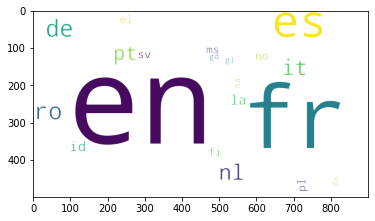

In [22]:
wordcloud = WordCloud(height=500, width=900, relative_scaling=0.6,max_words=20,
                background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate_from_frequencies(dict(source_language))
plt.imshow(wordcloud,interpolation='bilinear')
plt.savefig("docs/img/wordcloud-translation.png")

In [23]:
def insert_translation(text):
    trans_text=[]
    for word in text.split():
        try:
            trans_text.append(list(translated_dict_all[word])[0])
        except:
            trans_text.append(word)
    return ' '.join(trans_text) 

In [24]:
df_ns['product_name']=df_ns['product_name'].apply(insert_translation)

In [25]:
def extract_words_by_grade(df,nutritional_grade='a'):
    '''applies the text handling utilities to the subset of the dataframe corresponding to 
    nutritional_grade and returns a dictionnary containg the words and their count'''
    df_e=df[df['nutrition_grade_fr']==nutritional_grade].copy()
    prod_name=list(df_e['product_name'].values)
    name_concat=[]
    for i in prod_name: 
        for j in i.split(): 
            name_concat.append(j)
                
    name_concat=remove_numbers(name_concat)

    return OrderedDict(sorted(Counter(name_concat).items(),\
                                  key = lambda kv : kv[1], reverse=True))

## Creation of the Word Representation
We create a dictionnary using the previously defined functions for all the nutrition grades. We will also translate the words since the product names come in different languages (fr,de,es,en,etc). For now, we have a problem since the google API stops working after having translated 500 words which is problematic...

In [26]:
# create a dictionnary for all nutrition grades
grade_dict={}
for i in np.unique(df_ns['nutrition_grade_fr']):
    grade_dict[i]=extract_words_by_grade(df_ns,nutritional_grade=i)

In [27]:
df_ns

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
8,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,salade carottes rapees,NaN,NaN,...,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,1.0,1.0
15,0000000001281,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517830801,2018-02-05T11:40:01Z,1527070794,2018-05-23T10:19:54Z,tarte noix coco,NaN,"barquette,plastique",...,22.0,15.5,27.3,21.9,4.4,4.6,0.10,0.040,14.0,14.0
23,0000000001885,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1511180337,2017-11-20T12:18:57Z,1518126491,2018-02-08T21:48:11Z,compote poire,NaN,NaN,...,0.0,0.0,36.0,27.0,3.6,0.6,0.00,0.000,-2.0,-2.0
27,0000000002257,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1520506122,2018-03-08T10:48:42Z,1561463749,2019-06-25T11:55:49Z,salade macedoine legumes,NaN,NaN,...,12.7,1.0,3.9,1.0,NaN,1.9,0.27,0.108,1.0,1.0
48,0000000005005,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1521663684,2018-03-21T20:21:24Z,1545934272,2018-12-27T18:11:12Z,abondance,NaN,NaN,...,33.0,21.6,0.1,0.1,NaN,25.0,1.30,0.520,14.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023441,9999991042711,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1548781141,2019-01-29T16:59:01Z,1557676679,2019-05-12T15:57:59Z,riz lait,NaN,NaN,...,6.1,4.3,21.0,14.0,NaN,2.9,0.08,0.032,7.0,7.0
1023443,9999991042742,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1539597358,2018-10-15T09:55:58Z,1552297682,2019-03-11T09:48:02Z,mousse chocolat noir,85 g,NaN,...,27.0,17.0,19.0,18.0,NaN,6.0,0.19,0.076,17.0,17.0
1023444,9999991149090,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1519146449,2018-02-20T17:07:29Z,1545339064,2018-12-20T20:51:04Z,riz parfume,NaN,NaN,...,0.5,0.0,80.0,0.0,NaN,7.0,0.00,0.000,0.0,0.0
1023448,9999999004360,http://world-en.openfoodfacts.org/product/9999...,kiliweb,1548086277,2019-01-21T15:57:57Z,1558357406,2019-05-20T13:03:26Z,minis beignets,NaN,NaN,...,20.2,6.0,30.9,10.4,NaN,7.4,1.10,0.440,15.0,15.0


### Visualization of the word representation
In this section, we provide barplots for each nutrition grade allowing us to vizualize which words are the most frequent per grade.

In [47]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [48]:
def plot_wordcloud(nutritionalgrade='a'):
    mask = np.array(Image.open('img\grade_'+nutritionalgrade+'.PNG'))
    wordcloud = WordCloud(relative_scaling=0.8,max_words=1000,
                mask=mask,background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate_from_frequencies(dict(grade_dict[nutritionalgrade]))
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=(10,20))
    write_correct_letter(nutritionalgrade)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [49]:
def write_correct_letter(nutritionalgrade):
    if nutritionalgrade=='a':
        plt.text(22, 148, 'A', fontsize=130,color='seagreen',alpha=0.7)
    if nutritionalgrade=='b':
        plt.text(115, 140, 'B', fontsize=130,color='lightgreen',alpha=0.7)
    if nutritionalgrade=='c':
        plt.text(208, 138, 'C', fontsize=130,color='gold',alpha=0.7)
    if nutritionalgrade=='d':
        plt.text(298, 143, 'D', fontsize=130,color='orange',alpha=0.7)
    if nutritionalgrade=='e':
        plt.text(405, 145, 'E', fontsize=130,color='orangered',alpha=0.7)

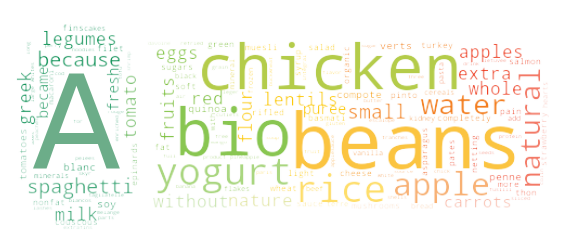

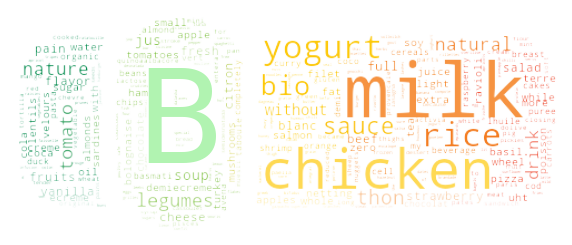

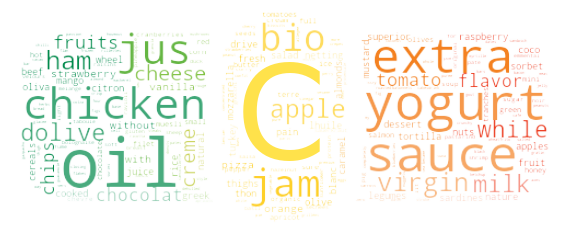

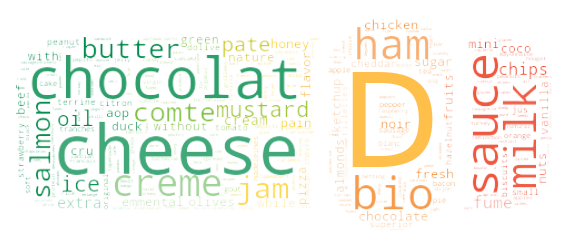

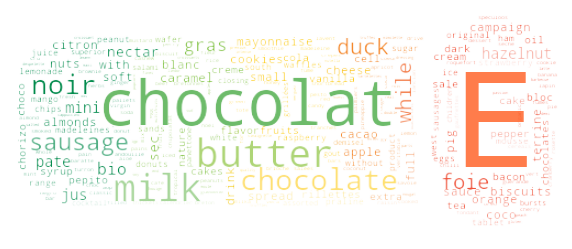

In [227]:
for i in ['a','b','c','d','e']:
    plot_wordcloud(nutritionalgrade=i)

#### Comments about the visualization 
- Grade A : We notice that the most frequent word is "bio" followed by "chicken", "beans", and "apple". In general the words are related to vegetables/fruits. 
- Grade B : The first words are "milk" and "chicken". "Bio" now falls in third position. In general, the words are milk or meat/fish related. Some are also vegetables/fruit related.
- Grade C : The first words are now "sauce" and "extra" and "bio" comes in 6th position. We notice that the words are less about raw products, but represent more already processed goods (sauce, jam, etc). "Chocolat" makes its appearance in 18th position.
- Grade D : "Chocolat" jumps to first position, followed by "sauce". We notice a lot of words that are cream or cheese related. 
- Grade E : "Chocolat" remains in first position, but the gap in the number of occurences between the first and second word increases a lot (now "Chocolat" appears more than 6000 times, as opposed to 2700 times in Grade D). We notice a lot of words related to very fat products ("butter", "gras", "mayonnaise", ...), and also a lot of deserts. 

In [28]:
del df_of_clean  #delete a big variable to be able to load instacart

# Instacart dataset

In this section, we work with the [instacart](https://www.instacart.com/) dataset. In a first time, we make a initial analysis with this dataset alone, and then in a second time we link it with the openfoodfacts dataset.

**Dataset description**

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

## Load the data and initial analysis

In [51]:
aisles_path='Data/instacart_2017_05_01/aisles.csv'
dep_path='Data/instacart_2017_05_01/departments.csv'
orders_path='Data/instacart_2017_05_01/orders.csv'
products_path='Data/instacart_2017_05_01/products.csv'
o_ppath='Data/instacart_2017_05_01/order_products__prior.csv'

In [52]:
aisles=pd.read_csv(aisles_path)
dep=pd.read_csv(dep_path)
orders=pd.read_csv(orders_path)
products=pd.read_csv(products_path)
oprior=pd.read_csv(o_ppath)

In [53]:
products.product_id.is_unique # The key values of each dataset

True

In [54]:
orders.order_id.is_unique

True

In [55]:
products=products.set_index('product_id')

In [56]:
print(oprior.shape)
oprior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Aggregate and save prior orders

Since the aggregation takes time, we only do this step once and save the data to a pickle file to be reused. We aggregate the prior orders on the order id, that way we have the list of products for each order. The oprior_agg dataframe contains the data aggregated on the order id.

In [ ]:
oprior_agg=oprior.groupby('order_id').agg(list)

In [50]:
oprior_agg.head()

,product_id,add_to_cart_order,reordered
order_id,,,
2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 1, 0, 1, 0, 1, 1, 1, 0]"
3,"[33754, 24838, 17704, 21903, 17668, 46667, 174...","[1, 2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1, 1]"
4,"[46842, 26434, 39758, 27761, 10054, 21351, 225...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
5,"[13176, 15005, 47329, 27966, 23909, 48370, 132...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,"[40462, 15873, 41897]","[1, 2, 3]","[0, 0, 0]"


In [51]:
oprior_agg.to_pickle('Data/instacart_2017_05_01/oprior_agg.pkl')

In [53]:
oprior_agg=pd.read_pickle('Data/instacart_2017_05_01/oprior_agg.pkl')

In [54]:
# Example : we query all the products associated with the order_id=6
products.loc[oprior_agg.product_id[6]]

,product_id,product_name,aisle_id,department_id
40462,40463,Organic Roasted Garlic Hummus,67,20
15873,15874,Burnt Caramel Tiles,45,19
41897,41898,Organic Stress Ease Tea,94,7


### Product centric dataframe 
We create a new dataframe products, where each row represents a product. The columns contain amongst other the product name and the number of times it has been ordered. The dataframe is ordered by descending number of orders.

In [ ]:
tmp=oprior.groupby('product_id').count()[['order_id']]
tmp.columns=['n_orders']
products=products.merge(tmp,left_index=True, right_index=True)

In [5]:
products=products.sort_values('n_orders',ascending=False)

NameError: name 'products' is not defined

In [6]:
products.head(n=2500)

NameError: name 'products' is not defined

#### Reducing the size of the dataframe
Since we are not interested in the integrality of the instacart dataset, but only in the most popular products, we only keep the products which have been ordered the most.

In [7]:
# only 5% of the products have more than 2286 orders, we can focus on those products
products.quantile(0.95)

NameError: name 'products' is not defined

In [8]:
# create a dataframe containing only the 5% most popular products
prod_95=products[products['n_orders']>=products.quantile(0.95)['n_orders']].copy()

NameError: name 'products' is not defined

In [9]:
sns.distplot(np.log(products['n_orders'].values))
plt.xlabel('Log of the number or orders')
plt.show()

NameError: name 'products' is not defined

In [17]:
# lets save prod_95 so we can use it later
prod_95.to_pickle('Data/instacart_2017_05_01/prod_95.pkl')

In [29]:
prod_95=pd.read_pickle('Data/instacart_2017_05_01/prod_95.pkl')

In [30]:
prod_95['product_name']=prod_95['product_name'].apply(lowercase_all)

## Assign a nutrition grade to instacart products

We now want to assign a nutrition grade to the instacart items, similar to the openfoodfacts grade. The way we compute this similarity score is the following. We first add a column for each nutritional grade to prod_95. Then for each word in the product's name, if it is present in the dictionnary of a nutritional grade, we add the number of occurences of that word in the dictionnary. The nutritional grade for a given category is given by the number of occurences of the words of the product's name in the category's dictionnary, divided by the length of the given product's name and the respective dictionnary, to avoid bias.

In [31]:
nutritional_grades=['a','b','c','d','e']

In [32]:
# Compute the nutrion grade
for grade in nutritional_grades:
    tmp=[]
    #check_list=[i[0] for i in translated_dict['a']]
    for name in prod_95['product_name']:
        aux=[]
        for word in name.split():
            if word in grade_dict[grade]:
                 aux.append(grade_dict[grade][word])
        tmp.append(sum(aux)/(len(grade_dict[grade])*len(name.split())))
    prod_95[grade]=tmp
        

In [33]:
def normalize_perline(df,cols=nutritional_grades):
    ''' Function to normalize per row the grades'''
    tmp=sum(df[nutritional_grades])
    if tmp!=0:
        for i in nutritional_grades:
            df[i]=100*df[i]/tmp
    return df

In [34]:
# we also normalize the grades per row
prod_95=prod_95.apply(normalize_perline,axis=1)

In [35]:
prod_95

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e
24852,24853,shredded 3 cheese italian,21,16,472565,6.489222,8.408470,12.962971,57.833349,14.305989
13176,13177,warrior blend vanilla dietary supplement,65,11,379450,19.113978,17.123399,12.539959,28.981408,22.241256
21137,21138,fat free low sodium poppyseed dressing,89,13,264683,37.564432,28.721417,12.849570,12.608182,8.256399
21903,21904,earth paste amazingly natural toothpaste peppe...,20,11,241921,43.256293,23.907517,16.515723,11.680562,4.639905
47209,47210,fresh farmed tilapia fillet,15,12,213584,29.818558,27.221998,14.366848,17.192001,11.400596
...,...,...,...,...,...,...,...,...,...,...
20590,20591,italian bread,112,3,2288,47.773768,22.429899,20.110097,7.424799,2.261437
2974,2975,"napkins, 2-ply, mega pack",54,17,2287,15.738086,20.787216,17.332871,18.680454,27.461373
9422,9423,caramel truffle bars,37,1,2286,2.284928,5.975992,22.244781,21.795649,47.698650
33095,33096,halloween vanilla mini cupcakes,8,3,2286,9.706461,9.587566,13.596017,28.465161,38.644795


## Relationship between nutrition grade and other attributes of products

Now that we have computed the nutrition grade for the instacart items, we can see how it is related to other attibutes of the items. For now, we focused on the relationship between nutrition grade and department id, but the analysis will include later on several other attributes.

In [36]:
dep

NameError: name 'dep' is not defined

NameError: name 'dep' is not defined

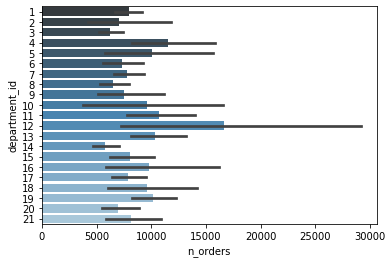

In [37]:
g = sns.barplot(data=prod_95,y='department_id',x='n_orders',palette="Blues_d", orient="h")
g.set(yticklabels = dep.department)

In the above plot we see where most of the orders where made, following the department ids.
* Most orders are made in the department number 4, department "produce"
* Following are department 21 which define the missing product, and department 7 which are beverages
* Department 11, personal care, is amongst the less bought department

In [67]:
#sns.pairplot(prod_95,vars=nutritional_grades,hue='department_id',palette="Blues_d")

### Boxplots

For each nutrition grade, we plot a boxplot of the values of this grade for each department id. 

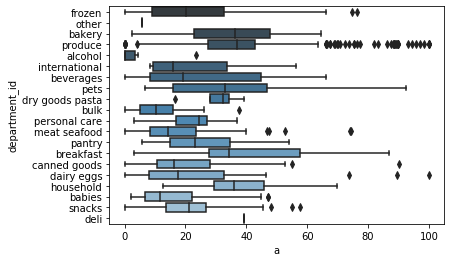

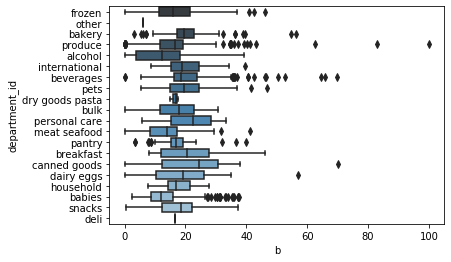

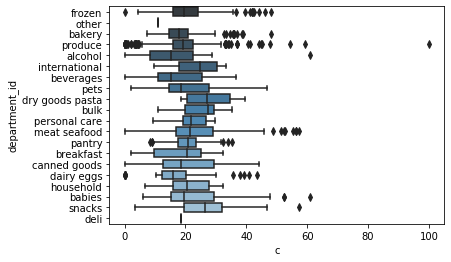

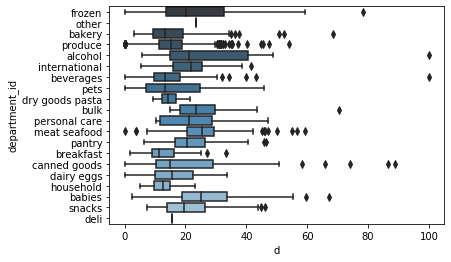

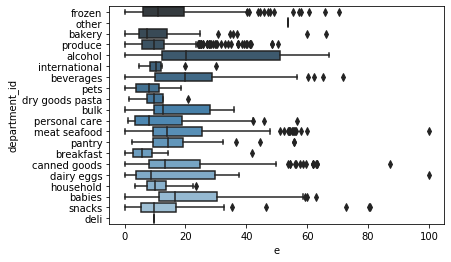

In [68]:
for grade in nutritional_grades:
    fig,ax=plt.subplots()
    g = sns.boxplot(data=prod_95,y='department_id',x=grade,palette="Blues_d",ax=ax, orient="h")
    g.set(yticklabels = dep.department)

#### Analysis of the boxplots 
As such we can define some analysis : 
* Departments that will contain the most products with grade A and as such be defined as the healthiest departments are : canned goods, bakery, dry goods pasta and produce
    * By looking at this we observe that canned good are the best but, in our computation, the contains often words of vegetables and as such are quite well ranked
    * Alcohol is definitely the one product that is not ranked in grade A
* For grade B and C, the numbers are all close together, we cannot really sort something out of those plots, but we can differenciate them from A, and we see the apparition of alcohol, and also that international products seem to have a lower grade
* For grade D, departments like alcohol, dairy eggs and frozen become predominent, obviously as we know they are not good for our health
* Finally, grade E contains mostly alcohol, but also other beverages and snacks have a higher mean.
    * with this plot we also can notice the difference with plot A where departments that are healthy obviously disappear in plot E

# For the future
Here we talk about the future of this project.

We have noted a few points and a few ideas that we'd like to implement:
1. Link better both datasets to have more analysis to do
2. Create rankings:
    1. What products are good for such diet
    2. How good are the products the most bought on the instacart dataset
    3. Discover a standard profile of buyer
3. Possibly augment our translation dictionary to completement the Google one that doesn't seem to be working

Also we will begin to write our report and prepare the poster for our final presentation

In [38]:
nutritional_grades=['a', 'b', 'c', 'd', 'e']

In [39]:
def max_grade(row):
    tmp = max(row['a'], row['b'], row['c'], row['d'], row['e'])
    for grade in ['a','b','c','d','e']:
        if tmp == row[grade]:
            return grade
def weighted_avg(row):
    #w=[5,4,3,2,1]
    w=[2,1,0,-1,-2]
    return np.dot(row[['a','b','c','d','e']].values,w)/100

In [40]:
#orders_merged = pd.merge(oprior, orders, on='order_id')
# add a column for containing the max nutrition score for each product
prod_95["max_score"]=prod_95.apply(max_grade, axis=1)
prod_95["weighted_score"]=prod_95.apply(weighted_avg, axis=1)
prod_95=prod_95[prod_95["weighted_score"]!=0]

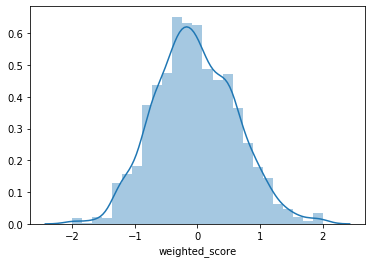

In [41]:
sns.distplot(prod_95["weighted_score"],bins=25)

In [42]:
grade_freq=Counter(df_ns['nutrition_grade_fr'].values)

In [43]:
def bar_per_grade(x):
    grade_freq=Counter(np.array(x))
    aux=[]
    for i in nutritional_grades: 
        aux.append(grade_freq[i])
    plt.bar(range(len(aux)),aux, align='center')
    plt.xticks(range(len(aux)), nutritional_grades)
    plt.show()

In [71]:
tmp_p95 = prod_95.max_score.value_counts()
tmp_off = df_ns.nutrition_grade_fr.value_counts()

In [72]:
tmp_off = tmp_off.sort_index(ascending=False)
tmp_p95 = tmp_p95.sort_index(ascending=False)

<bound method Series.keys of e    57186
d    87944
c    62397
b    39460
a    42763
Name: nutrition_grade_fr, dtype: int64>

In [78]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Bar(y=list(tmp_off.index), x=tmp_off.values, name="OpenFoodFact", orientation='h'), row=1, col=1)
fig.add_trace(go.Bar(y=list(tmp_p95.index), x=tmp_p95.values, name="Instacart", orientation='h'), row=2, col=1)
fig.update_layout(title="Items per grade, per dataset")
f = open("docs/html/items_per_grade.html", "w")
f.write(fig.to_html())
f.close()


# Bias in the nutrition score between the two datasets

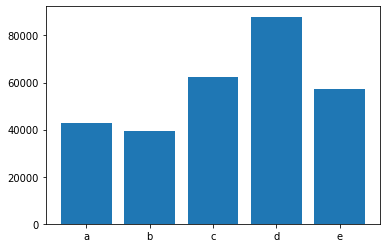

In [45]:
bar_per_grade(df_ns['nutrition_grade_fr'])

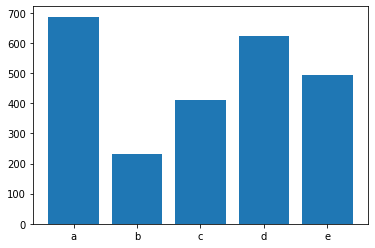

In [46]:
bar_per_grade(prod_95.max_score)

In [47]:
grade_freq=Counter(df_ns['nutrition_grade_fr'].values)
total_sum=sum(list(grade_freq.values()))
grade_dict={}
for grade in nutritional_grades:
    grade_dict[grade]=grade_freq[grade]/total_sum

In [48]:
grade_quantile=[]
tmp=0
for grade in nutritional_grades[::-1]:
    tmp+=grade_dict[grade]
    grade_quantile.append(np.quantile(prod_95['weighted_score'].values,tmp))

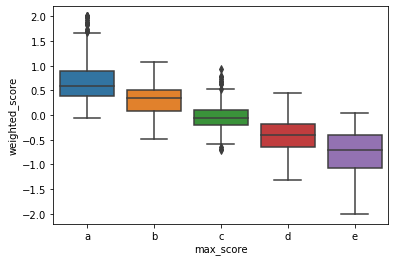

In [49]:
fig,ax=plt.subplots()
sns.boxplot(y='weighted_score',x='max_score',order=['a','b','c','d','e'],data=prod_95,ax=ax)

#for gq in grade_quantile:
#    plt.plot(ax.get_xbound(),2*[gq],'k--')

In [50]:
prod_95 = prod_95[(prod_95.department_id != 8) & (prod_95.department_id != 11)
                             & (prod_95.department_id != 17) & (prod_95.department_id != 18)]

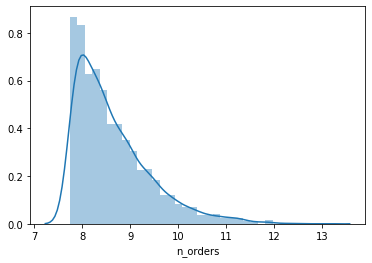

In [51]:
sns.distplot(np.log(prod_95.n_orders))

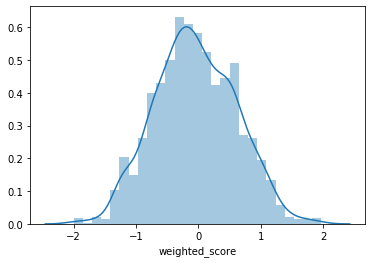

In [52]:
sns.distplot(prod_95.weighted_score)

In [53]:
prod_95['grade_times_orders']=prod_95['weighted_score'].values*np.log(prod_95['n_orders'].values)

In [54]:
prod_95=prod_95.sort_values(by='grade_times_orders')

In [55]:
prod_95.head(20)

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,weighted_score,grade_times_orders
18441,18442,enz armor spermicidal lubricant latex condoms,6,2,15304,0.000000,0.000000,0.000000,0.000000,100.000000,e,-2.000000,-19.271739
10070,10071,"juice, escape",31,7,12121,0.000000,0.000000,0.000000,0.000000,100.000000,e,-2.000000,-18.805390
40706,40707,holiday cheers,31,7,84255,0.000000,0.000000,6.790902,21.807263,71.401835,e,-1.646109,-18.669519
33716,33717,assorted chocolates,45,19,7476,0.808372,0.245993,0.764264,5.368653,92.812717,e,-1.891314,-16.869482
46650,46651,chocolates,45,19,6536,0.638249,0.582671,0.452568,3.633270,94.693241,e,-1.911606,-16.793611
14159,14160,seasonal,27,5,3517,0.000000,0.000000,0.000000,0.000000,100.000000,e,-2.000000,-16.330727
33352,33353,powdered donut holes,93,3,6942,1.418641,0.647554,2.514816,12.921113,82.497875,e,-1.744320,-15.429115
24964,24965,european chocolate,45,19,109778,2.981778,7.008700,8.214221,20.290686,61.504614,e,-1.303277,-15.126109
48104,48105,gingerbread spice cookies,105,13,8019,0.999898,2.396174,5.937916,15.652929,75.013084,e,-1.612831,-14.498658
34197,34198,fortune cookies,66,6,5185,0.902399,2.000704,5.576015,14.823787,76.697095,e,-1.644125,-14.063062


In [56]:
quantiles_gto=np.quantile(prod_95.grade_times_orders.values,[0,0.2, 0.4, 0.6, 0.8,1])
quantiles_gto[-1]+=0.1
quantiles_gto[0]-=0.1

def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def popular_names(q,n=5): 
    prod_q=prod_95[(prod_95.grade_times_orders<=quantiles_gto[q]) & (prod_95.grade_times_orders>quantiles_gto[q-1])]
    prod_q_text=sanitize_text_row(' '.join(prod_q.product_name.values)).split()
    prod_q_dict=OrderedDict(sorted(Counter(prod_q_text).items(),key = lambda kv : kv[1], reverse=True))
    nouns=[]
    for word in list(prod_q_dict.keys()):
        syns = wordnet.synsets(word)
        if syns:
            word_type=most_frequent([i.lexname().split('.')[0] for i in syns])
            if word_type=='noun':
                nouns.append(word)
            if len(nouns)==n:
                return nouns

In [57]:
quant_noun=[]
for q in range(1,len(quantiles_gto)):
    quant_noun.append(popular_names(q,n=5))

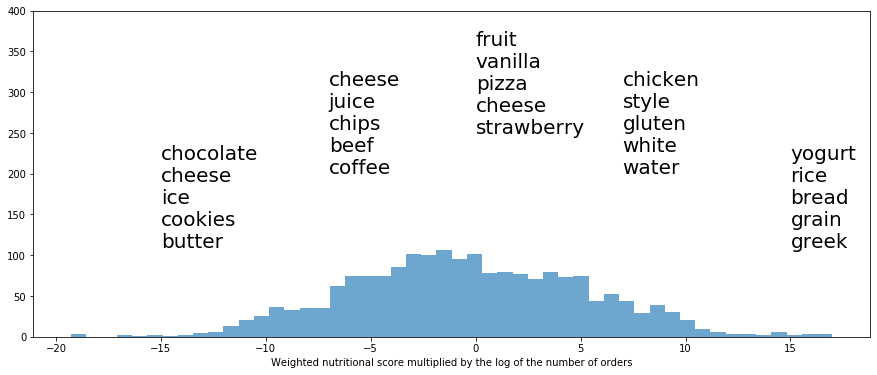

<Figure size 432x288 with 0 Axes>

In [71]:
import pylab
xt=[-15,-7,0,7,15]
yt=[110,200,250,200,110]

fig,ax=plt.subplots(figsize=(15,6))
n,bins,_ = plt.hist(prod_95.grade_times_orders,bins=50,alpha=0.65)
for j,i in enumerate(quant_noun):
    plt.text(xt[j],yt[j],'\n'.join(i),fontsize=20)
plt.ylim((0,400))
plt.xlabel('Weighted nutritional score multiplied by the log of the number of orders')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('docs/img/test.png')

In [116]:
topa = prod_95[prod_95.max_score=="a"].sort_values(by='a').head(5)
topb = prod_95[prod_95.max_score=="b"].sort_values(by='b').head(5)
topc = prod_95[prod_95.max_score=="c"].sort_values(by='c').head(5)
topd = prod_95[prod_95.max_score=="d"].sort_values(by='d').head(5)
tope = prod_95[prod_95.max_score=="e"].sort_values(by='e').head(5)


In [117]:
topa["ranking"]=topa.a.rank(ascending=False)
topb["ranking"]=topb.b.rank(ascending=False)
topc["ranking"]=topc.c.rank(ascending=False)
topd["ranking"]=topd.d.rank(ascending=False)
tope["ranking"]=tope.e.rank(ascending=False)

In [118]:
topd

,product_id,product_name,aisle_id,department_id,n_orders,a,b,c,d,e,max_score,weighted_score,grade_times_orders,ranking
14429,14430,organic turmeric gold fields tea,94,7,2761,21.134729,19.732853,16.286609,22.172950,20.672860,d,-0.015164,-0.120146,5.0
37718,37719,organic licorice root herbal tea,94,7,4924,21.168769,19.858819,16.316923,22.182020,20.473469,d,-0.009326,-0.079289,4.0
5746,5747,organic nighty night valerian herbal tea,94,7,4927,21.234995,19.963332,16.242612,22.247321,20.311740,d,-0.004375,-0.037197,3.0
22255,22256,organic throat comfort tea,94,7,2430,21.363532,19.669209,16.244238,22.356110,20.366912,d,-0.006937,-0.054075,2.0
25230,25231,organic spearmint tea,94,7,3656,21.328209,19.677676,16.311384,22.426425,20.256306,d,-0.006049,-0.049630,1.0


In [122]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=1)
fig.add_trace(go.Bar(x=topa.a.values, y=topa.product_name.values, name="A", orientation='h'), row=1, col=1)
fig.add_trace(go.Bar(x=topb.b.values, y=topb.product_name.values, name="B", orientation='h'), row=2, col=1)
fig.add_trace(go.Bar(x=topc.c.values, y=topc.product_name.values, name="C", orientation='h'), row=3, col=1)
fig.add_trace(go.Bar(x=topd.d.values, y=topd.product_name.values, name="D", orientation='h'), row=4, col=1)
fig.add_trace(go.Bar(x=tope.e.values, y=tope.product_name.values, name="E", orientation='h'), row=5, col=1)
fig.update_layout(title='Products that are the most of each grade')
f=open("docs/html/top5grades.html","w")
f.write(fig.to_html())
f.close()

In [ ]:
=